In [1]:
import cv2 as cv
from cv2.typing import MatLike
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import os
import shutil
from dataclasses import dataclass, field
from functools import cache
from __future__ import annotations

In [2]:

@dataclass
class Defect:
    '''
    A dataclass to hold the locations of potential defects
    '''
    top: int
    bottom: int
    left: int
    right: int
    pixels: set[tuple[int, int]] = field(default_factory=lambda: set())

    @property
    def width(self) -> int:
        return self.right - self.left + 1
    
    @property
    def height(self) -> int:
        return self.bottom - self.top + 1
    
    @property
    def top_left(self) -> tuple[int, int]:
        return (self.top, self.left)
    
    @property
    def bottom_right(self) -> tuple[int, int]:
        return (self.bottom, self.right)
    
    @property
    def area(self) -> int:
        return self.width * self.height
    
    def is_enclosed(self, other: Defect, image: MatLike) ->  bool:
        x_cut = len(image[0])//18
        y_cut = len(image)//18
        return max(0, self.top-y_cut) <= other.top \
                and other.bottom <= min(self.bottom+y_cut, len(image)-1) \
                and max(0, self.left-x_cut) <= other.left \
                and other.right <= min(self.right+x_cut, len(image[0]-1))

            

    def insert_pixel(self, pixel: tuple[int, int]):
        self.top = min(self.top, pixel[0])
        self.bottom = max(self.bottom, pixel[0])
        self.left = min(self.left, pixel[1])
        self.right = max(self.right, pixel[1])

        self.pixels.add(pixel)    
        
    def merge(self, other: Defect):
        self.top = min(self.top, other.top)
        self.bottom = max(self.bottom, other.bottom)
        self.left = max(0, min(self.left, other.left))
        self.right = max(self.right, other.right)
        
        for p in other.pixels:
            self.insert_pixel(p)

    def enlarge(self, image: MatLike, min_dim: int = 20):
        if (rem := self.height - min_dim-1) <= 0:
            self.top = max(0, self.top + rem//2)
            rem = self.height - min_dim -1
            self.bottom = min(self.bottom - rem, len(image)-1)

        if (rem := self.width - min_dim-1) <= 0:
            self.left = max(0, self.left + rem//2)
            rem = self.width - min_dim-1
            self.right = min(self.right - rem, len(image[0])-1)

    def __repr__(self) -> str:
        return f"({self.top}, {self.bottom}, {self.left}, {self.right}) {list(self.pixels)}"

In [3]:
def find_defects(edges: np.ndarray) -> list[Defect]:
    defects: list[Defect] = []
    for y, row in enumerate(edges):
        for (x, val) in enumerate(row):
            if val == 255:
                # see if point in a defect
                curr_def = None
                for defect in defects:
                    if (y, x) in defect.pixels:
                        curr_def = defect
                        defects.remove(defect)
                        break
                if curr_def is None:
                    curr_def = Defect(y, y, x, x)
                    curr_def.insert_pixel((y, x))

                # find neighbors
                for n in get_neighbors(5):
                    if 0 <= (x + n[1]) < len(row) and 0 <= (y+n[0]) < len(edges):
                        if edges[y+n[0], x+n[1]] != 0:
                            curr_def.insert_pixel((y+n[0], x+n[1]))
                        
                defects.append(curr_def)
    return defects

@cache
def get_neighbors(dist: int):
    out = []
    for i in range(0, dist+1):
        for j in range(-dist, dist+1):
            if i != 0 or j != 0:
                out.append((i, j))
    return out



In [4]:
def remove_small_edges(defects: list[Defect], edges: MatLike, cutoff: int):
    to_remove: list[Defect] = []

    for d in defects:
        if d.width <= cutoff and d.height <= cutoff:
            to_remove.append(d)

    for d in to_remove:
        for p in d.pixels:
            edges[p[0], p[1]] = 0
        defects.remove(d)
    return defects, edges

In [5]:

def find_all_edges(image_path: str) -> tuple[MatLike, MatLike]:
    image = cv.imread(image_path)
    image_g = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    blur_width = len(image[0])//150
    if blur_width % 2 == 0:
        if 4 <= blur_width:
            blur_width -= 1
        else:
            blur_width += 1
    image_blured = cv.GaussianBlur(image_g, (blur_width, blur_width), 0)

    edges = cv.Canny(image_blured, 100, 250)

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image,edges

In [6]:
def remove_enclosed_defects(defects: list[Defect], image: MatLike) -> list[Defect]:
    to_remove: list[tuple[Defect, Defect]] = []

    for d in defects:
        for o in defects:
            if o in to_remove:
                continue
            if d != o and d.is_enclosed(o, image):
                to_remove.append((d, o))

    for d, p in to_remove:
        p.merge(d)
        if d in defects:
            defects.remove(d)
    return defects

rd1.jpg


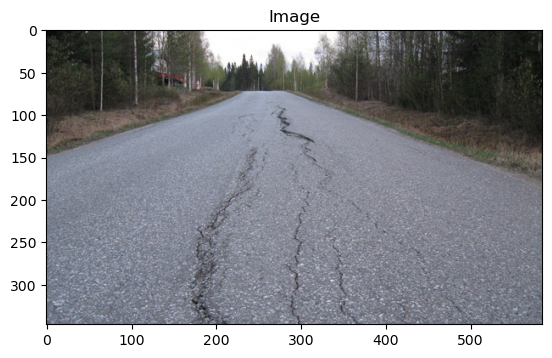

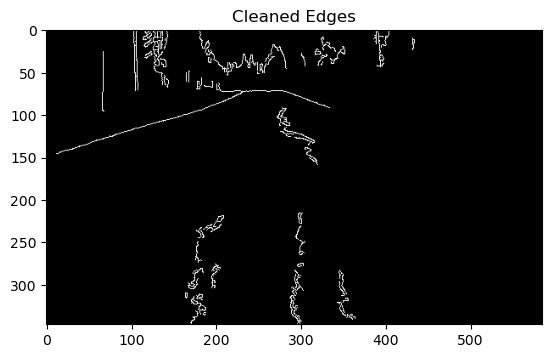

rd2.jpg


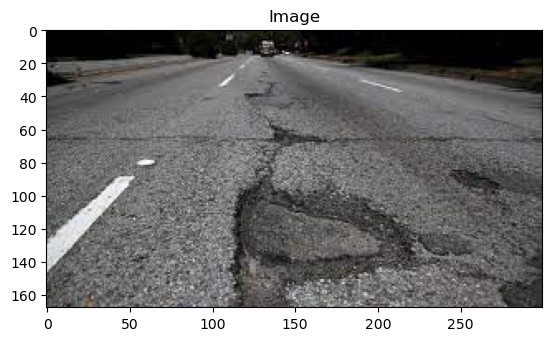

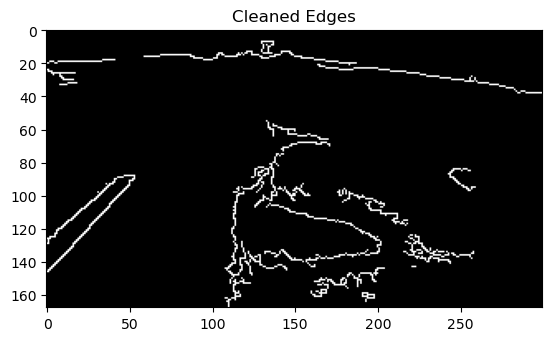

rd3.jpg


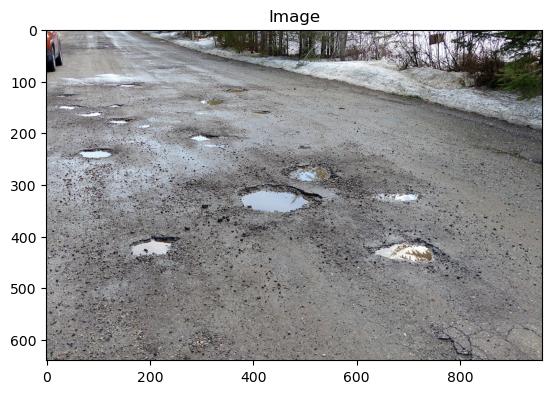

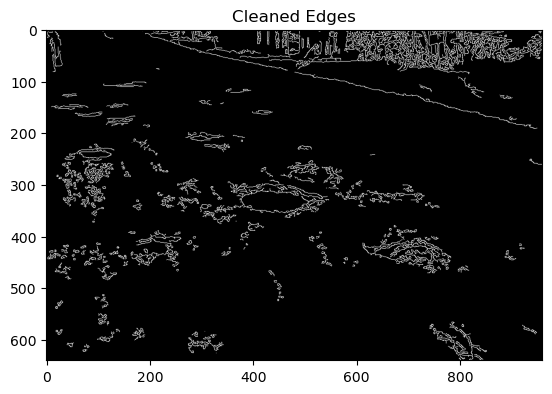

rd4.jpg


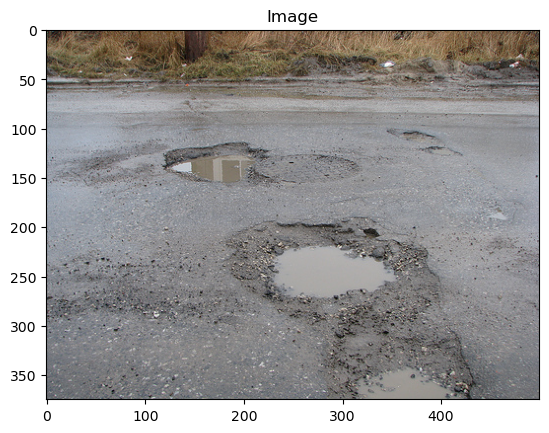

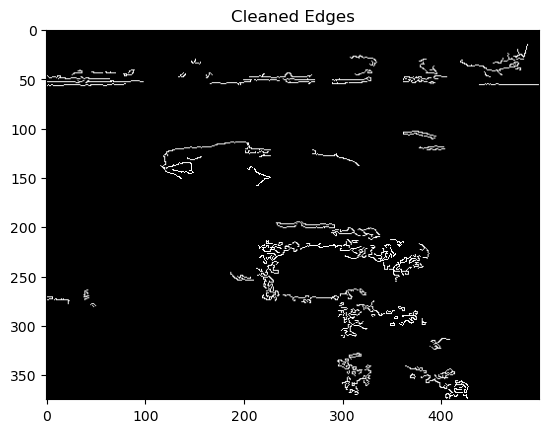

rd5.jpg


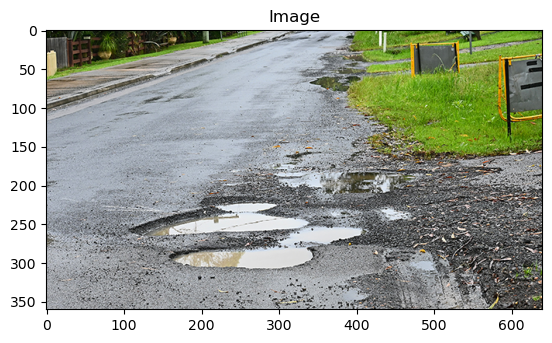

In [7]:

def generate_potential_defect_pics(image_folder: str):
    for image_name in os.listdir(image_folder):
        print(image_name)
        image, edges = find_all_edges(image_folder + '/' + image_name)
        plt.title('Image')
        plt.imshow(image, cmap='gray')
        plt.show()


        defects = find_defects(edges)
        defects, new_edges = remove_small_edges(defects, edges, 20)
        defects = remove_enclosed_defects(defects, image)
        for d in defects:
            d.enlarge(image, min_dim=len(image[0])//20)

        plt.title('Cleaned Edges')
        plt.imshow(new_edges, cmap='gray')
        plt.show()

        create_defect_files(image_name, image, defects)

def create_defect_files(image_name: str, image: MatLike, defects: list[Defect]):
    if not os.path.isdir('output'):
        os.mkdir('output')
    image_name = image_name.split('.')[0]
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    for i, defect in enumerate(defects):
        cv.imwrite( f'output/{image_name}_{i}.jpg' , image[defect.top:defect.bottom,defect.left:defect.right])

shutil.rmtree('output')
generate_potential_defect_pics('./resources')
